# [**Clustering with Scikit-Learn in Python**](https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python)

# **First case study**

**1. Exploring the dataset**

In [ ]:
import pandas as pd

# load the authors dataset that has been stored as a .csv files in a folder called "data" in the same directory as the Jupyter Notebook
df_authors = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DNP_ancient_authors.csv", index_col="authors").drop(columns=["Unnamed: 0"])

# display dataset structure with the pandas .info() method
print(df_authors.info())

# show first 5 rows
print(df_authors.head(5))

# display some statistics
print(df_authors.describe())

In [2]:
ninety_quantile = df_authors["word_count"].quantile(0.9)
df_authors = df_authors[df_authors["word_count"] <= ninety_quantile]

**2. Imports and additional functions**

In [3]:
from sklearn.preprocessing import StandardScaler as SS # z-score standardization
from sklearn.cluster import KMeans, DBSCAN # clustering algorithms
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from sklearn.neighbors import NearestNeighbors # for selecting the optimal eps value when using DBSCAN
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer

In [4]:
def silhouettePlot(range_, data):

    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=(15,8))
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=ax[q][mod])
        ax[q][mod].set_title("Silhouette Plot with n={} Cluster".format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show()
    fig.savefig("silhouette_plot.png")

In [6]:
def elbowPlot(range_, data, figsize=(10,10)):

    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)

    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    fig.savefig("elbow_plot.png")

In [7]:
def findOptimalEps(n_neighbors, data):

    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [8]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):

    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

**3. Standardizing the DNP Ancient Authors Dataset**

In [9]:
scaler = SS()
DNP_authors_standardized = scaler.fit_transform(df_authors)
df_authors_standardized = pd.DataFrame(DNP_authors_standardized, columns=["word_count_standardized", "modern_translations_standardized", "known_works_standardized", "manuscripts_standardized", "early_editions_standardized", "early_translations_standardized", "modern_editions_standardized", "commentaries_standardized"])
df_authors_standardized = df_authors_standardized.set_index(df_authors.index)

**4. Feature selection**

In [ ]:
selected_features = progressiveFeatureSelection(df_authors_standardized, max_features=3, n_clusters=3)

In [11]:
df_standardized_sliced = df_authors_standardized[selected_features]

**5. Choosing the right amount of clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

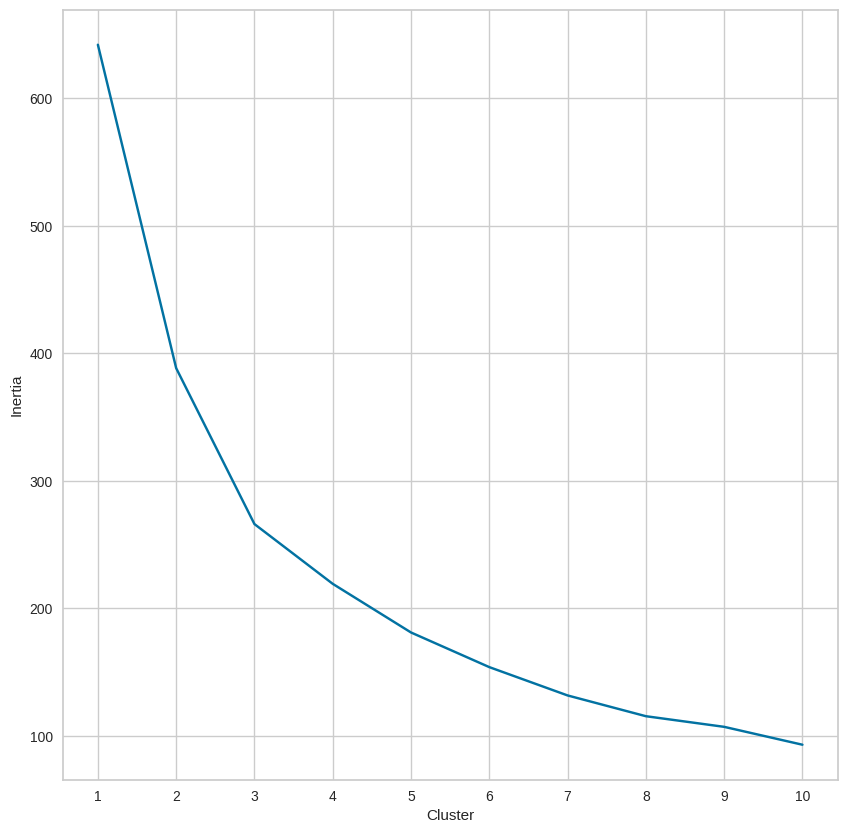

In [12]:
elbowPlot(range(1,11), df_standardized_sliced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

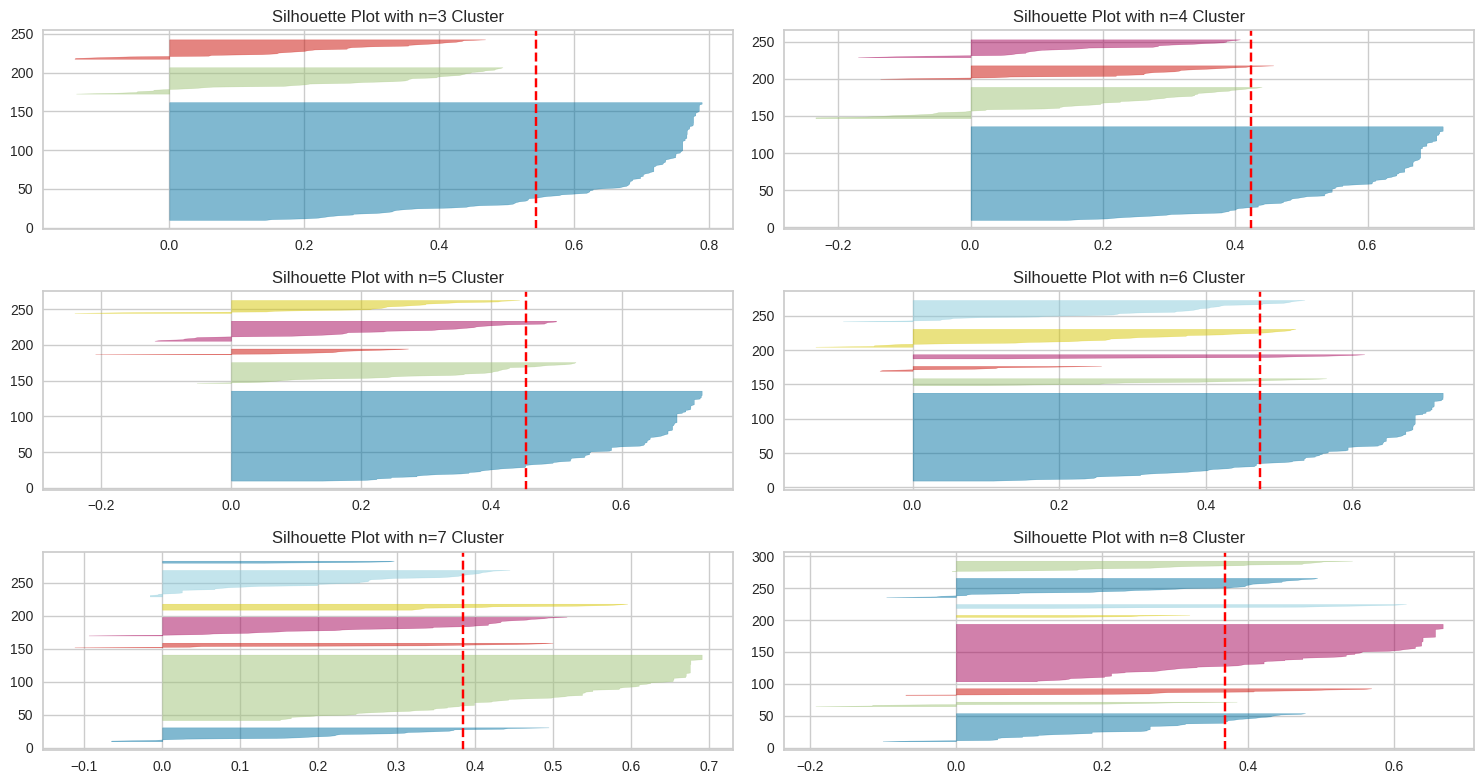

In [13]:
silhouettePlot(range(3,9), df_standardized_sliced)

**6. n=5 K-means analysis of the DNP ancient authors dataset**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-14-164dca96a5bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized_sliced["clusters"] = cluster_labels


<Axes: xlabel='pc_1', ylabel='pc_2'>

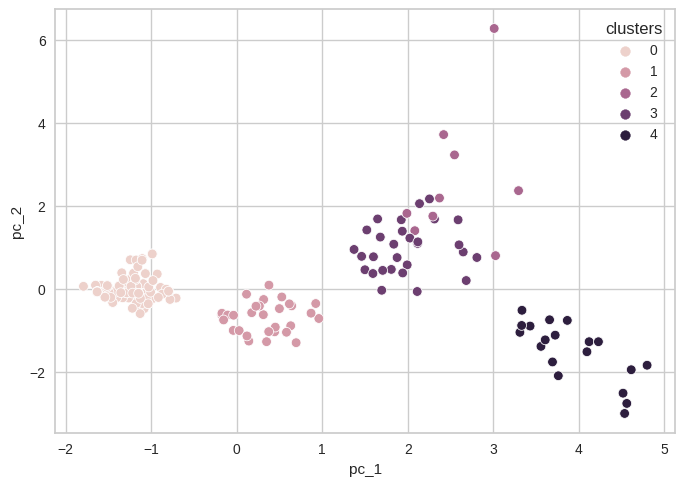

In [14]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized_sliced)
df_standardized_sliced["clusters"] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
authors_standardized_pca = pca.fit_transform(df_standardized_sliced)
df_authors_standardized_pca = pd.DataFrame(data=authors_standardized_pca, columns=["pc_1", "pc_2"])
df_authors_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_authors_standardized_pca)

# **Second case study**

**1. Loading the dataset and exploratory data analysis**

In [15]:
df_abstracts = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RELIGION_abstracts.csv").drop(columns="Unnamed: 0")
df_abstracts.info()
df_abstracts.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     701 non-null    object
 1   abstract  701 non-null    object
 2   link      701 non-null    object
 3   volume    701 non-null    object
dtypes: object(4)
memory usage: 22.0+ KB


,title,abstract,link,volume
count,701,701,701,701
unique,701,701,701,40
top,Norwegian Muslims denouncing terrorism: beyond...,"In contemporary European societies, Muslims ar...",https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...
freq,1,1,1,41


**2. TF-IDF Vectorization**

In [17]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

def lemmatizeAbstracts(x):
        doc = nlp(x)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        text_string = " ".join(new_text)
        # getting rid of non-word characters
        text_string = re.sub(r"[^\w\s]+", "", text_string)
        text_string = re.sub(r"\s{2,}", " ", text_string)
        return text_string

df_abstracts["abstract_lemma"] = df_abstracts["abstract"].apply(lemmatizeAbstracts)
df_abstracts.to_csv("/content/drive/MyDrive/Colab Notebooks/RELIGION_abstracts.csv")

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")
df_abstracts_tfidf = tfidf.fit_transform(df_abstracts["abstract_lemma"])

In [20]:
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=250, strip_accents="unicode", min_df=10, max_df=200)
tfidf_religion_array = tfidf.fit_transform(df_abstracts["abstract_lemma"])
df_abstracts_tfidf = pd.DataFrame(tfidf_religion_array.toarray(), index=df_abstracts.index, columns=tfidf.get_feature_names_out())
df_abstracts_tfidf.describe()

,academic,account,activity,address,african,agency,aim,allow,american,analyse,...,use,value,various,view,way,western,woman,work,world,year
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,...,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.017395,0.017696,0.010628,0.011038,0.011331,0.009074,0.010499,0.009149,0.015161,0.012112,...,0.033088,0.014265,0.013611,0.021308,0.027670,0.021195,0.018491,0.028035,0.028887,0.014515
std,0.063817,0.067372,0.051658,0.047012,0.065546,0.054176,0.045395,0.042515,0.067962,0.051397,...,0.074381,0.061424,0.052614,0.064546,0.062501,0.077924,0.095834,0.074827,0.073781,0.053082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.494113,0.709618,0.501507,0.360322,0.737092,0.672583,0.386343,0.409185,0.624531,0.453473,...,0.609089,0.828967,0.530361,0.514821,0.364839,0.724380,0.941353,0.604321,0.492094,0.367367


**3. Dimensionality reduction using PCA**

In [21]:
pca = PCA(n_components=10, whiten=False, random_state=42)
abstracts_pca = pca.fit_transform(df_abstracts_tfidf)
df_abstracts_pca = pd.DataFrame(data=abstracts_pca)

**4. Applying K-Means clustering on textual data**

In [22]:
kmeans = KMeans(n_clusters=100, random_state=42)
abstracts_labels = kmeans.fit_predict(df_abstracts_pca)
df_abstracts_labeled = df_abstracts.copy()
df_abstracts_labeled["cluster"] = abstracts_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
df_abstracts_labeled[df_abstracts_labeled["cluster"] == 75][["title", "cluster"]]

,title,cluster
18,‘Just leave it blank’ non-religious children a...,75
58,The promise of the universal: non-Buddhists’ a...,75
126,"Possession consciousness, religious individual...",75
216,The metropolis and evangelical life: coherence...,75
246,Where angels fear to tread: neurophenomenology...,75
454,How to Prove Divinities? Experiencing and Defe...,75
592,"The visions of Luciano Perez, contemporary nat...",75
624,Contemporary Theravāda and Zen Buddhist attitu...,75


In [24]:
df_abstracts_labeled[df_abstracts_labeled["cluster"] == 15][["title", "cluster"]]

,title,cluster
154,Lifelong minority religion: routines and refle...,15
161,Quiet beauty: problems of agency and appearanc...,15
189,Remembering Karbala in the diaspora: religious...,15
388,Renunciation feminised? Joint renunciation of ...,15
398,Conclusion: Construction sites at the juncture...,15
506,Art as Neglected ‘Text’ for the Study of Gende...,15
526,The Fundamental Unity of the Conservative and ...,15
551,"Hindu Women, Destiny and Stridharma",15
645,Dorothy day as autobiographer,15


In [25]:
df_abstracts_labeled[df_abstracts_labeled["cluster"] == 84][["title", "cluster"]]

,title,cluster
8,Engineering self and civil society: the promis...,84
71,From socialization to self-socialization? Expl...,84
90,Governing religious identities: law and legibi...,84
196,Using census data in the management of religio...,84
197,Evidencing superdiversity in the census and be...,84
198,Secular or nonreligious? Investigating and int...,84
203,Woven together: advocacy and research as compl...,84
307,Mind and mood in the study of religion,84
336,Searching for salvation: An analysis of US rel...,84
445,Determining the Place of Religion: Native Amer...,84


**5. Applying DBSCAN clustering on textual data**

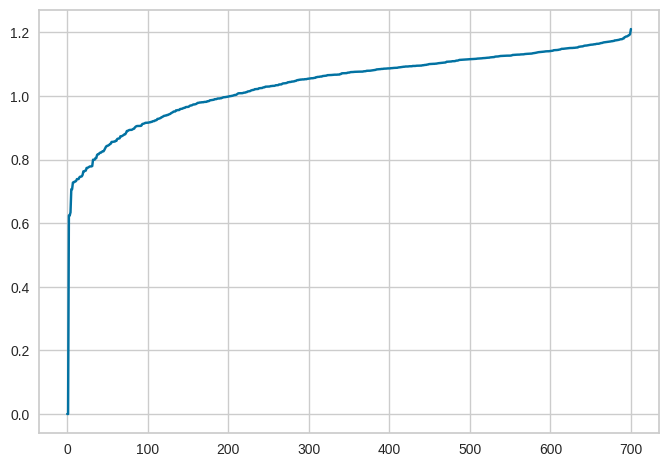

In [26]:
findOptimalEps(2, df_abstracts_tfidf)

In [27]:
dbscan = DBSCAN(eps=0.2, metric="euclidean")
dbscan_labels = dbscan.fit_predict(df_abstracts_pca)
df_abstracts_dbscan = df_abstracts.copy()
df_abstracts_dbscan["cluster"] = dbscan_labels
df_abstracts_dbscan["cluster"].unique()

array([ 0, -1,  1,  3,  2,  4,  5])

In [28]:
df_abstracts_dbscan[df_abstracts_dbscan["cluster"] == 1][["title", "cluster"]]

,title,cluster
14,Imagining Buddhist modernism: the shared relig...,1
20,Why Durkheim really thought that Buddhism was ...,1
158,Textbook Buddhism: introductory books on the B...,1
275,On the market: consumption and material cultur...,1
406,A new Buddhist sect?: The Dhammakāya temple an...,1
439,Recent trends in Sri Lankan Buddhism,1
471,William James and Buddhism: American Pragmatis...,1
559,Buddhist Environmental Ethics and Detraditiona...,1
589,Inclusivism and the spiritual journey of Marie...,1
620,Buddhadharma and contemporary ethics,1


In [29]:
df_abstracts_dbscan[df_abstracts_dbscan["cluster"] == 2][["title", "cluster"]]

,title,cluster
209,Three cognitive routes to atheism: a dual-proc...,2
282,THE CULTURAL TRANSMISSION OF FAITH Why innate ...,2
321,"Religion is natural, atheism is not: On why ev...",2
322,Atheism is only skin deep: Geertz and Markusso...,2
323,The relative unnaturalness of atheism: On why ...,2
378,The science of religious beliefs,2


**6. Visualizing DBSCAN results**

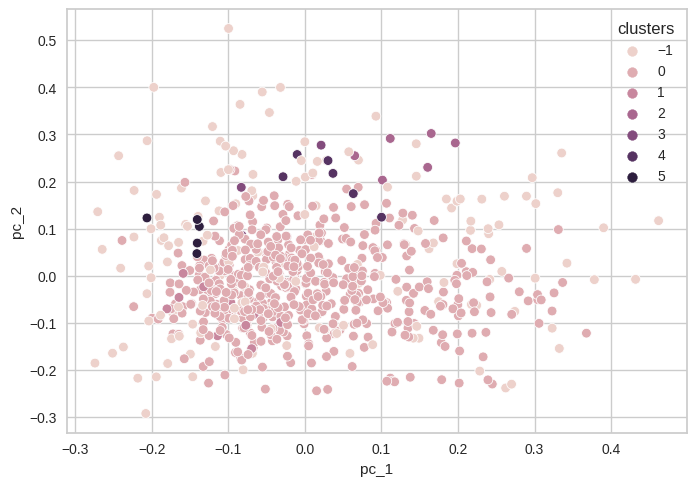

In [30]:
pca = PCA(n_components=2, whiten=False, random_state=42)
dbscan_pca_2d = pca.fit_transform(df_abstracts_tfidf)
df_dbscan_2d = pd.DataFrame(data=dbscan_pca_2d, columns=["pc_1", "pc_2"])
df_dbscan_2d["clusters"] = dbscan_labels
sns_plot = sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_dbscan_2d)
sns_plot.get_figure().savefig("clustering-with-sklearn-in-python-fig12.png")